# Possible Crafting Analysis Example

Note 1: The structure is generated with ChatGPT, based on the pure Python example in [`example_calculator_for_example_items.py`](https://github.com/WladHD/pyoe2-craftpath/tree/main/python_examples/example_calculator_for_example_items.py).

Note 2: The start and target item was provided by [github/Dboire9](https://github.com/Dboire9/), thanks!

This notebook demonstrates an example workflow for calculating crafting routes in Path of Exile 2. It includes:
- Loading example start and target items.
- Fetching economy and item data.
- Generating an item matrix and computing statistics.
- Displaying results in interactive Pandas tables with pretty-print for each route.
- Summary of top routes and currency groups.



## 1. Imports and Version Check
Import necessary modules for PoE2 crafting analysis, JSON parsing, and Pandas display.

Check for new version

In [17]:
import pyoe2_craftpath as pc
import pandas as pd

new_version_available = pc.check_for_updates_and_print()

2025-12-12T21:57:41.251135Z  INFO You are up to date running pyoe2-craftpath with version 0.5.0!
You can always check out https://github.com/WladHD/pyoe2-craftpath if you encounter issues or have ideas.


## 2. Setup Cache and URLs
Define URLs for item data ([Craft of Exile](https://www.craftofexile.com/?game=poe2)) and market data ([PoE Ninja](https://poe.ninja/)). The economy data is gathered for the League `Standard`.

In [18]:
COE_MAP = {
    "./cache/coe2.json": "https://www.craftofexile.com/json/poe2/main/poec_data.json"
}

ECONOMY_MAP = {
    "./cache/pn_abyss.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Abyss",
    "./cache/pn_currency.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Currency",
    "./cache/pn_essences.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Essences",
    "./cache/pn_ritual.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Ritual"
}

## 3. Fetch and Parse Item and Market Data
I've implemented a caching function, that can fetch and cache the given structure in `COE_MAP` and `ECONOMY_MAP`. Use that or provide required CoE's and PN's jsons on your own.

In [19]:
raw_fetched_responses_coe = pc.retrieve_contents_from_urls_with_cache_unstable_order(
    cache_url_map=COE_MAP,
    max_cache_duration_in_sec=60*60*24
)

raw_fetched_responses_economy = pc.retrieve_contents_from_urls_with_cache_unstable_order(
    cache_url_map=ECONOMY_MAP,
    max_cache_duration_in_sec=60*60
)

coe_data = pc.CraftOfExileItemInfoProvider.parse_from_json(
    raw_fetched_responses_coe[0])
economy = pc.PoeNinjaMarketPriceProvider.parse_from_json_list(
    raw_fetched_responses_economy)

2025-12-12T21:57:41.279316Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/coe2.json'
2025-12-12T21:57:41.296213Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_currency.json'
2025-12-12T21:57:41.300417Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_abyss.json'
2025-12-12T21:57:41.304297Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_ritual.json'
2025-12-12T21:57:41.308143Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_essences.json'


## 4. Load Example Items
Load raw string for starting and target items and parse using the `CraftOfExileEmulatorItemImport` class. The content of `startitem_good_essence_bow.json` and `targetitem_good_essence_bow.json` is generated by the Emulator in [craftofexile.com](https://www.craftofexile.com/?game=poe2) using the Export function (under History/Spending on the right).

In [20]:
with open('example_items/startitem_good_essence_bow.json', 'r', encoding='utf-8') as f:
    start_raw_string = f.read()
with open('example_items/targetitem_good_essence_bow.json', 'r', encoding='utf-8') as f:
    end_raw_string = f.read()

start_item = pc.CraftOfExileEmulatorItemImport.parse_itemsnapshot_from_string(
    start_raw_string, coe_data)
end_item = pc.CraftOfExileEmulatorItemImport.parse_itemsnapshot_from_string(
    end_raw_string, coe_data)

print(start_item.to_pretty_string(coe_data, True))
print(end_item.to_pretty_string(coe_data, True))

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
[Tier 1+, ilvl 82, Prefix] '#% increased Physical Damage'
[Tier 2+, ilvl 66, Suffix] '+# to Dexterity'

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Rare, ItemLevel: 100, Sockets: 0
[Tier 1+, ilvl 72, Suffix, Ess.] '#% chance to gain Onslaught on Killing Hits with this Weapon'
[Tier 1+, ilvl 82, Prefix] '#% increased Physical Damage'
[Tier 1+, ilvl 72, Suffix, Ess.] '+# to Level of all Attack Skills'
[Tier 3+, ilvl 60, Prefix] 'Adds # to # Physical Damage'
[Tier 1+, ilvl 72, Prefix, Ess.] 'Gain #% of Damage as Extra Lightning Damage'
[Tier 1+, ilvl 65, Suffix, Des.] '#% increased Attack Speed, Companions have #% increased Attack Speed'



## 5. Generate Item Matrix
Use `MatrixBuilderPreset.HappyPathMatrixBuilder` to create a crafting matrix from start to target items. Currently only one implementation exists to build the item matrix. Refer to the [README](https://github.com/WladHD/pyoe2-craftpath) for implementation details. You can write your own Rust addon and create a new `DynMatrixBuilder`, which can be passed as the argument `matrix_builder`.

In [21]:
matrix_builder_instance = pc.MatrixBuilderPreset.HappyPathMatrixBuilder.get_instance()

calc = pc.Calculator.generate_item_matrix(
    starting_item=start_item,
    target=end_item,
    item_provider=coe_data,
    market_info=economy,
    matrix_builder=matrix_builder_instance
)

print(f"Matrix contains {len(calc.matrix)} items")

2025-12-12T21:57:41.630959Z  INFO generate_item_matrix: Using 'Happy Path Matrix Builder' to generate item matrix ...
Matrix contains 686 items
2025-12-12T21:57:41.631011Z  INFO generate_item_matrix: Description: Builds an optimized item matrix containing reachable items starting from the given item, that only come closer to the target item (target_proximity).
2025-12-12T21:57:41.631052Z  INFO generate_item_matrix: Starting propagation ...
2025-12-12T21:57:41.649758Z  INFO generate_item_matrix: AffixSpecifier { affix: AffixId(5118), fractured: false, tier: AffixTierConstraints { tier: AffixTierLevel(3), bounds: Minimum } }
2025-12-12T21:57:41.649788Z  INFO generate_item_matrix: AffixSpecifier { affix: AffixId(5120), fractured: false, tier: AffixTierConstraints { tier: AffixTierLevel(1), bounds: Minimum } }
2025-12-12T21:57:41.649800Z  INFO generate_item_matrix: AffixSpecifier { affix: AffixId(5923), fractured: false, tier: AffixTierConstraints { tier: AffixTierLevel(1), bounds: Minimum

## 6. Calculate Statistics
Compute crafting statistics using analyzers for chance, efficiency, and cost. Here again, analyzer instances are of type `DynStatisticAnalyzerPaths`, if you want to handle the statistic login in Rust. You can also let this program calculate all possible paths, and create your own statistics in Python yourself.

In [22]:
def calculate_stat_results(calc: pc.Calculator, analyzer_preset: pc.StatisticAnalyzerPathPreset, coe_data: pc.ItemInfoProvider, economy: pc.MarketPriceProvider, max_routes=100):
    instance = analyzer_preset.get_instance()
    res = calc.calculate_statistics(
        item_provider=coe_data,
        market_provider=economy,
        max_routes=max_routes,
        max_ram_in_bytes=1_000_000_000,
        statistic_analyzer=instance
    )
    return res, instance


chance_results, chance_instance = calculate_stat_results(
    calc, pc.StatisticAnalyzerPathPreset.UniquePathChance, coe_data, economy)
efficiency_results, efficiency_instance = calculate_stat_results(
    calc, pc.StatisticAnalyzerPathPreset.UniquePathEfficiency, coe_data, economy)
cost_results, cost_instance = calculate_stat_results(
    calc, pc.StatisticAnalyzerPathPreset.UniquePathCost, coe_data, economy)

2025-12-12T21:57:43.398667Z  INFO calculate_statistics: Using 'Unique Path by Highest Chance' to calculate statistics ...
2025-12-12T21:57:43.398716Z  INFO calculate_statistics: Description: Retrieves N number of unique paths memory efficiently from all possible combinations, sorted by chance.
2025-12-12T21:57:43.398743Z  INFO calculate_statistics:get_statistic: Generating unique craft paths based on item matrix
2025-12-12T21:57:43.543557Z  INFO calculate_statistics:get_statistic:finalize_routes: Collecting 100 routes ...
2025-12-12T21:57:43.544412Z  INFO calculate_statistics:get_statistic:finalize_routes: Routes collected successfully.
2025-12-12T21:57:43.544501Z  INFO calculate_statistics: Successfully calculated statistics.
2025-12-12T21:57:43.545180Z  INFO calculate_statistics: Using 'Unique Path by Efficient Cost' to calculate statistics ...
2025-12-12T21:57:43.545196Z  INFO calculate_statistics: Description: Retrieves N number of unique paths memory efficiently from all possible 

## 7. Calculate Currency Group Statistics
Compute grouped statistics using `CurrencyGroupChance` analyzer. Same as unique paths, but with the goal of collecting routes into groups by the applied currency sequence. The instance is `DynStatisticAnalyzerCurrencyGroups`.

The calculation is memory expensive for deep paths, so define the amount of RAM you're comfortable with giving for this calculation.

In [23]:
group_chance_instance = pc.StatisticAnalyzerCurrencyGroupPreset.CurrencyGroupChance.get_instance()
groups = calc.calculate_statistics_currency_group(
    item_provider=coe_data,
    market_provider=economy,
    max_ram_in_bytes=1_000_000_000,
    statistic_analyzer=group_chance_instance
)

2025-12-12T21:57:44.561495Z  INFO calculate_statistics_currency_group: Using 'Currency Groups by Highest Chance (No Unique Paths)' to calculate statistics ...
2025-12-12T21:57:44.561538Z  INFO calculate_statistics_currency_group: Description: Memory efficient implementation of currency sequence grouping. Unique paths are not kept, but instead immediatly summed, thus losing information but allowing memory efficient collection. Best combined with best N routes.
2025-12-12T21:57:44.561569Z  INFO calculate_statistics_currency_group:get_statistic:get_grouped_statistic_memory_efficient: Generating unique craft paths based on item matrix
2025-12-12T21:57:45.716657Z  INFO calculate_statistics_currency_group: Successfully calculated statistics.


## 8. Build Pandas DataFrames for Routes
Here is an example, of how the calculated data can be transformed, into a more interesting view. Keep in mind that a route per se has no name. So the position in the sorted list is to identify it (in this example).

Construct DataFrames for chance, efficiency, and cost results with pretty-printed routes.

In [24]:
def build_routes_df(routes: list[pc.ItemRoute], analyzer_instance: pc.DynStatisticAnalyzerPaths, coe_data: pc.ItemInfoProvider, economy: pc.MarketPriceProvider, calc: pc.Calculator, groups: list[pc.GroupRoute]):
    data = []
    for i, r in enumerate(routes):
        group = r.locate_group(calculated_groups=groups)

        currency_group = [node.currency_list for node in r.route]

        data.append({
            'Route': "#" + str(i + 1),
            'Chance': r.chance,
            'Cost per 1 (DIV)': analyzer_instance.calculate_cost_per_craft(currency_group, coe_data, economy).get_divine_value(),
            'Tries needed for 60 %': analyzer_instance.calculate_tries_needed_for_60_percent(r),
            'Group Chance': group.chance if group is not None else None,
            'Group Tries Needed':  group_chance_instance.calculate_tries_needed_for_60_percent(group) if group is not None else None,
            'Pretty Print': r.to_pretty_string(
                item_provider=coe_data,
                market_provider=economy,
                calculator=calc,
                groups=groups,
                statistic_analyzer=analyzer_instance
            )
        })
    return pd.DataFrame(data)


df_chance = build_routes_df(
    chance_results, chance_instance, coe_data, economy, calc, groups)
df_efficiency = build_routes_df(
    efficiency_results, efficiency_instance, coe_data, economy, calc, groups)
df_cost = build_routes_df(cost_results, cost_instance,
                          coe_data, economy, calc, groups)

### 9. Display Top Routes by Chance
Show a Pandas DataFrame and print pretty-printed route details.

Below is a simple example of how the calculated data can be used. Following examples show a printed table, as well as the raw console output I've coded to visualize routes. The information you want may be different, so adapt to your needs.

In [25]:
df_chance.head(3)

Route               Chance  Cost per 1 (DIV)  Tries needed for 60 %  \
0    #1  0.07291666666666666          4.028605                     13   
1    #2  0.07291666666666666          4.028605                     13   
2    #3  0.07291666666666666          4.028605                     13   

          Group Chance  Group Tries Needed  \
0  0.07291666666666666                  13   
1  0.07291666666666666                  13   
2  0.07291666666666666                  13   

                                        Pretty Print  
0  Group Chance: 7.29167% | Unique Routes: 1 | Tr...  
1  Group Chance: 7.29167% | Unique Routes: 1 | Tr...  
2  Group Chance: 7.29167% | Unique Routes: 1 | Tr...

In [26]:
for i, (_, row) in enumerate(df_chance.head(3).iterrows(), start=1):
    print(f"--- Route {i}: {row['Route']} ---")
    print(row['Pretty Print'])

--- Route 1: #1 ---
Group Chance: 7.29167% | Unique Routes: 1 | Tries needed for 60%: 13 | Cost per Craft: 8,908 EX | Cost for 60%: 115,795 EX
1. Greater Essence of Abrasion (48 EX) [ROUGH (!) avg. chance: 100.00000%]
2. Exalted Orb (2 EX) + Omen of Sinistral Exaltation (62 EX) [ROUGH (!) avg. chance: 100.00000%]
3. Perfect Essence of Battle (1,400 EX) + Omen of Dextral Crystallisation (1,425 EX) [ROUGH (!) avg. chance: 100.00000%]
4. Exalted Orb (2 EX) [ROUGH (!) avg. chance: 100.00000%]
5. Perfect Essence of Haste (3,405 EX) + Omen of Dextral Crystallisation (1,425 EX) [ROUGH (!) avg. chance: 50.00000%]
6. Perfect Essence of Electricity (369 EX) [ROUGH (!) avg. chance: 33.33333%]
7. Omen of Abyssal Echoes (724 EX) + Preserved Jawbone (29 EX) + Omen of the Liege (23 EX) [ROUGH (!) avg. chance: 43.75000%]

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
Exact Chance: 7

### 10. Console Display Top Routes by Efficiency

In [27]:
df_efficiency.head(3)

Route               Chance  Cost per 1 (DIV)  Tries needed for 60 %  \
0    #1  0.07291666666666666          4.028605                     13   
1    #2  0.07291666666666666          4.028605                     13   
2    #3  0.07291666666666666          4.028605                     13   

          Group Chance  Group Tries Needed  \
0  0.07291666666666666                  13   
1  0.07291666666666666                  13   
2  0.07291666666666666                  13   

                                        Pretty Print  
0  Group Chance: 7.29167% | Unique Routes: 1 | Tr...  
1  Group Chance: 7.29167% | Unique Routes: 1 | Tr...  
2  Group Chance: 7.29167% | Unique Routes: 1 | Tr...

In [28]:
for i, (_, row) in enumerate(df_efficiency.head(3).iterrows(), start=1):
    print(f"--- Route {i}: {row['Route']} ---")
    print(row['Pretty Print'])

--- Route 1: #1 ---
Group Chance: 7.29167% | Unique Routes: 1 | Tries needed for 60%: 13 | Cost per Craft: 8,908 EX | Cost for 60%: 115,795 EX
1. Greater Essence of Abrasion (48 EX) [ROUGH (!) avg. chance: 100.00000%]
2. Exalted Orb (2 EX) + Omen of Sinistral Exaltation (62 EX) [ROUGH (!) avg. chance: 100.00000%]
3. Perfect Essence of Haste (3,405 EX) + Omen of Dextral Crystallisation (1,425 EX) [ROUGH (!) avg. chance: 100.00000%]
4. Exalted Orb (2 EX) [ROUGH (!) avg. chance: 100.00000%]
5. Perfect Essence of Battle (1,400 EX) + Omen of Dextral Crystallisation (1,425 EX) [ROUGH (!) avg. chance: 50.00000%]
6. Perfect Essence of Electricity (369 EX) [ROUGH (!) avg. chance: 33.33333%]
7. Omen of Abyssal Echoes (724 EX) + Preserved Jawbone (29 EX) + Omen of the Liege (23 EX) [ROUGH (!) avg. chance: 43.75000%]

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
Exact Chance: 7

### 11. Console Display Top Routes by Cost

In [29]:
df_cost.head(3)

Route                   Chance  Cost per 1 (DIV)  Tries needed for 60 %  \
0    #1    6.2574372698838806e-6          2.363795                 146432   
1    #2  0.000011364979746181782          2.363795                  80624   
2    #3   0.00001420102653766467          2.363795                  64523   

              Group Chance  Group Tries Needed  \
0   0.00002045846380754855               44788   
1  0.000022729959492363564               40312   
2    0.0000202583612689384               45230   

                                        Pretty Print  
0  Group Chance: 0.00205% | Unique Routes: 2 | Tr...  
1  Group Chance: 0.00227% | Unique Routes: 2 | Tr...  
2  Group Chance: 0.00203% | Unique Routes: 2 | Tr...

In [30]:
for i, (_, row) in enumerate(df_cost.head(3).iterrows(), start=1):
    print(f"--- Route {i}: {row['Route']} ---")
    print(row['Pretty Print'])

--- Route 1: #1 ---
Group Chance: 0.00205% | Unique Routes: 2 | Tries needed for 60%: 44,788 | Cost per Craft: 5,227 EX | Cost for 60%: 234,077,758 EX
1. Regal Orb (1 EX) [ROUGH (!) avg. chance: 0.79904%]
2. Exalted Orb (2 EX) [ROUGH (!) avg. chance: 42.65420%]
3. Perfect Essence of Battle (1,400 EX) [ROUGH (!) avg. chance: 25.00000%]
4. Exalted Orb (2 EX) [ROUGH (!) avg. chance: 72.03164%]
5. Perfect Essence of Haste (3,405 EX) [ROUGH (!) avg. chance: 20.00000%]
6. Perfect Essence of Electricity (369 EX) [ROUGH (!) avg. chance: 33.33333%]
7. Preserved Jawbone (29 EX) + Omen of the Liege (23 EX) [ROUGH (!) avg. chance: 25.00000%]

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
Exact Chance: 0.00063% | Tries needed for 60%: 146,432 | Cost per Craft: 5,227 EX | Cost for 60%: 765,304,863 EX
0. Starting with ...
0.	[Tier 1+, ilvl 82, Prefix] '#% increased Physical Damage'

## 12. Console Display Best Currency Groups

Here are the best currency groups (which group unique paths based on the used currencies). The goal of this statistic is to provide a general overview, over how good the applied currencies are.

F. e. multiple unique paths may lead to a desired item, but each of them does not have a 100 % chance.
BUT together they COULD have a 100 % chance. Or a higher one in general.

The calculation is very memory expensive for deep routes, but if can be achieved, is worth it (IMO).

In [31]:
df_groups = pd.DataFrame([
    {
        'Group': f'Group {i+1}',
        'Group Chance': g.chance,
        'Group Tries Needed': group_chance_instance.calculate_tries_needed_for_60_percent(g),
        'Currencies': ', '.join(
            [' + '.join([c.get_item_name(item_info=coe_data) for c in currency_list.list])
             for currency_list in g.group]
        )
    }
    for i, g in enumerate(groups)
])

print(df_groups.head(3))

     Group         Group Chance  Group Tries Needed  \
0  Group 1  0.09114583333333331                  10   
1  Group 2  0.09114583333333333                  10   
2  Group 3  0.09114583333333333                  10   

                                          Currencies  
0  Greater Essence of Abrasion, Exalted Orb + Ome...  
1  Greater Essence of Abrasion, Exalted Orb + Ome...  
2  Greater Essence of Abrasion, Exalted Orb + Ome...  


## 13. Visualize Top Routes and Groups
Another example of how the results can be visualized. Same as with the pandas tables ... display the info you actually want.
Keep in mind, the naming of routes is handled by their respective position in the sorted lists. Change to your needs.

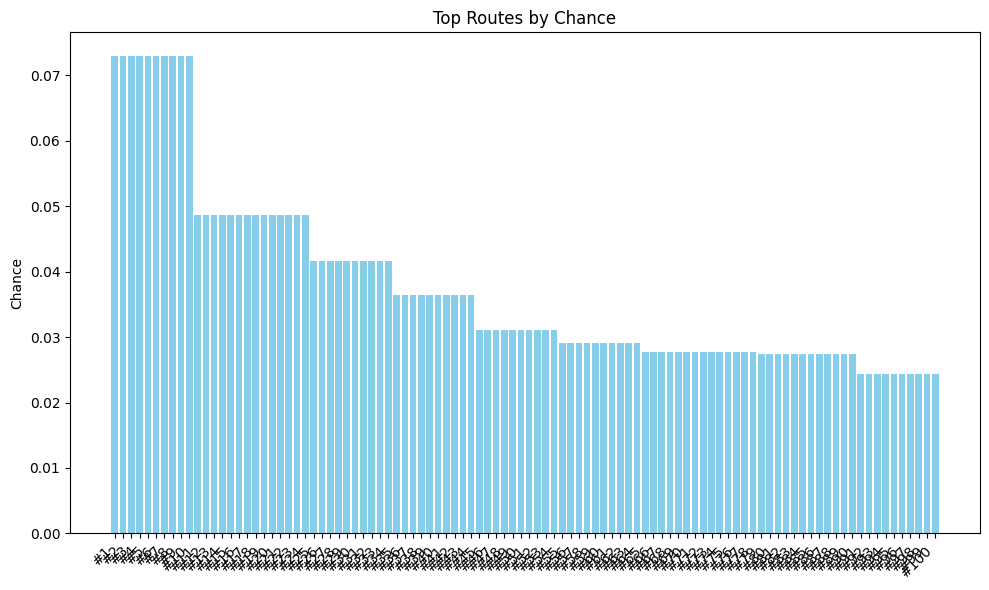

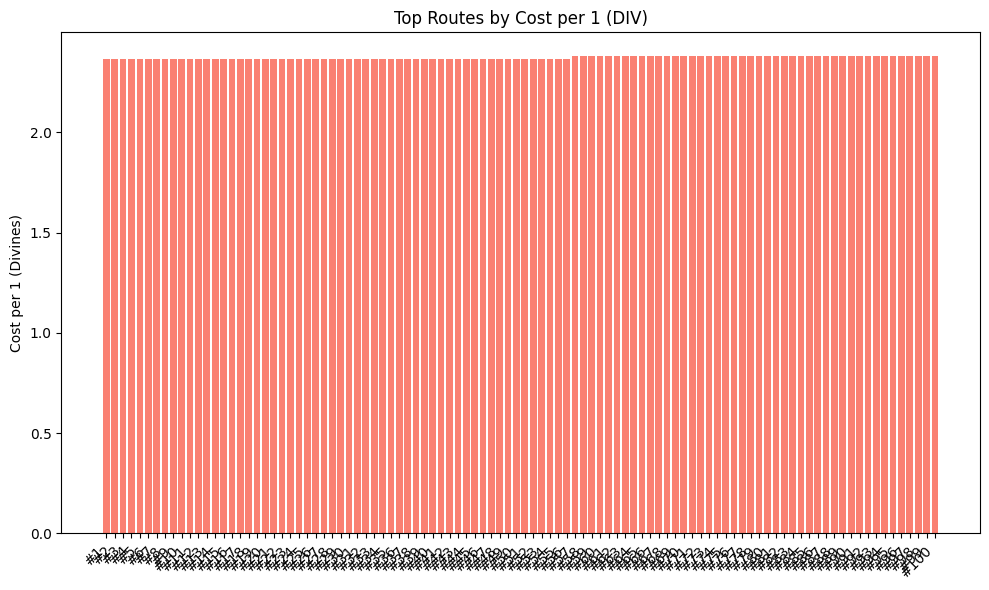

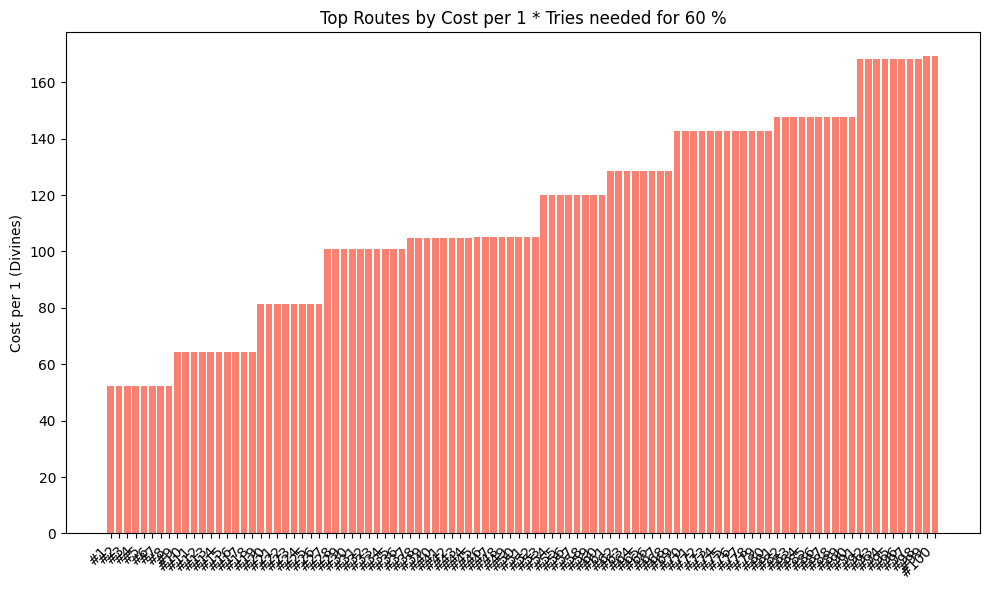

In [32]:
import matplotlib.pyplot as plt

# 14a. Top Routes by Chance
plt.figure(figsize=(10, 6))
plt.bar(df_chance['Route'], df_chance['Chance'].apply(
    lambda x: x.get_raw_value() if x else 0), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Chance')
plt.title('Top Routes by Chance')
plt.tight_layout()
plt.show()

# 14b. Top Routes by Cost per 1 (DIV)
plt.figure(figsize=(10, 6))
plt.bar(df_cost['Route'], df_cost['Cost per 1 (DIV)'].apply(
    lambda x: x if x else 0), color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cost per 1 (Divines)')
plt.title('Top Routes by Cost per 1 (DIV)')
plt.tight_layout()
plt.show()

# 14c. Top Routes by Cost per 1 * by tries needed for 60 percent (DIV)
heights = df_efficiency['Cost per 1 (DIV)'] * \
    df_efficiency['Tries needed for 60 %'].apply(lambda x: x if x else 0)

plt.figure(figsize=(10, 6))
plt.bar(df_efficiency['Route'], heights, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cost per 1 (Divines)')
plt.title('Top Routes by Cost per 1 * Tries needed for 60 %')
plt.tight_layout()
plt.show()

# # 14d. Top Currency Groups by Chance
# plt.figure(figsize=(10, 6))
# plt.bar(df_groups['Currencies'], df_groups['Group Chance'].apply(
#     lambda x: x.get_raw_value() if x else 0), color='lightgreen')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Group Chance')
# plt.title('Top Currency Groups by Chance')
# plt.tight_layout()
# plt.show()